# Exercise W4 Lecture 8

In [42]:
# imports
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import shapiro, bartlett
from matplotlib import pyplot as plt
import pandas

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf

# Useful functions

In [9]:
def square_it(x):
    return x**2

In [10]:
def log_it(x):
    return np.log10(x)

# Load data

In [3]:
data = pandas.read_csv('../Data/Rdataset_airquality.csv')

## 1. Remove NaNs

In [4]:
goods = []
for key in data.keys():
    good = np.isfinite(data[key].values)
    goods.append(good)
#
all_good = np.all(goods, axis=0)
#
data = data[all_good].copy()

In [6]:
data.rename(columns={'Solar.R': 'Rad'}, inplace=True)

In [7]:
year = 2015
dates = []
for index, row in data.iterrows():
    dates.append(f'{int(year)}-{int(row.Month)}-{int(row.Day)}')
dates = pandas.to_datetime(dates)
data['date'] = dates
data.set_index('date', inplace=True)
data.head()

,Ozone,Rad,Wind,Temp,Month,Day
date,,,,,,
2015-05-01,41.0,190.0,7.4,67,5,1
2015-05-02,36.0,118.0,8.0,72,5,2
2015-05-03,12.0,149.0,12.6,74,5,3
2015-05-04,18.0,313.0,11.5,62,5,4
2015-05-07,23.0,299.0,8.6,65,5,7


# 2. Pair plotting

<Figure size 432x288 with 0 Axes>

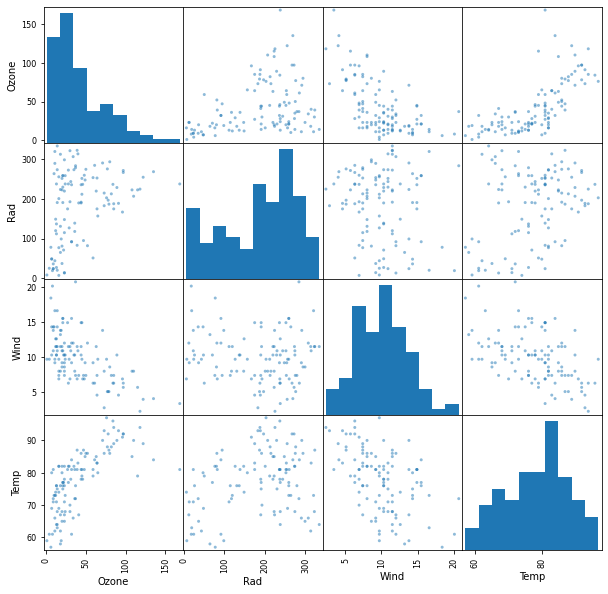

In [31]:
plt.clf()
_ = pandas.plotting.scatter_matrix(data[['Ozone', 'Rad', 'Wind', 'Temp']], figsize=(10,10))
#fig.set_size_inches((14, 9))

# 3. Fit Full Model

In [13]:
full_formula = "log_it(Ozone) ~ Wind + Rad + Temp + square_it(Wind) + square_it(Rad) + square_it(Temp) + Wind*Temp*Rad"  # -1 removes the Intercept
full_model = smf.glm(formula=full_formula, data=data).fit()#, family=sm.families.Binomial()).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_it(Ozone)   No. Observations:                  111
Model:                            GLM   Df Residuals:                      100
Model Family:                Gaussian   Df Model:                           10
Link Function:               identity   Scale:                        0.044893
Method:                          IRLS   Log-Likelihood:                 20.533
Date:                Wed, 20 Apr 2022   Deviance:                       4.4893
Time:                        10:02:42   Pearson chi2:                     4.49
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8920
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.2103      2.466      0.491      0.624      -3.623       6.044
Wind               -0.0424      0.140     -0.303      0.762      -0.316       0.231
Rad                 0.0120      0.007      1.810      0.070      -0.001       0.025
Temp               -0.0129      0.051     -0.253      0.800      -0.113       0.087
square_it(Wind)     0.0038      0.002      2.165      0.030       0.000       0.007
square_it(Rad)  -6.461e-06   3.06e-06     -2.112      0.035   -1.25e-05   -4.65e-07
square_it(Temp)     0.0003      0.000      0.916      0.360      -0.000       0.001
Wind:Temp          -0.0009      0.002     -0.531      0.596      -0.004       0.002
Wind:Rad           -0.0009      0.001     -1.493      0.136      -0.002       0.000
Temp:Rad           -0.0001   8.93e-05     -1.217      0.224      -0.000    6.64e-05
Wind:Temp:Rad      1.1e-05   7.84e-06      1.402      0.161   -4.38e-06    2.64e-05
===================================================================================
"""

## Drop the 3-way interaction

In [14]:
new_formula = "log_it(Ozone) ~ Wind + Rad + Temp + square_it(Wind) + square_it(Rad) + square_it(Temp) + Wind*Temp*Rad - Wind:Temp:Rad"  # -1 removes the Intercept
new_model = smf.glm(formula=new_formula, data=data).fit()#, family=sm.families.Binomial()).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_it(Ozone)   No. Observations:                  111
Model:                            GLM   Df Residuals:                      101
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                        0.045322
Method:                          IRLS   Log-Likelihood:                 19.453
Date:                Wed, 20 Apr 2022   Deviance:                       4.5775
Time:                        10:06:42   Pearson chi2:                     4.58
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8877
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.3269      2.345      0.992      0.321      -2.270       6.923
Wind               -0.1532      0.116     -1.324      0.185      -0.380       0.074
Rad                 0.0034      0.003      1.334      0.182      -0.002       0.008
Temp               -0.0269      0.050     -0.533      0.594      -0.126       0.072
square_it(Wind)     0.0036      0.002      2.064      0.039       0.000       0.007
square_it(Rad)  -7.048e-06   3.05e-06     -2.315      0.021    -1.3e-05   -1.08e-06
square_it(Temp)     0.0002      0.000      0.808      0.419      -0.000       0.001
Wind:Temp           0.0008      0.001      0.679      0.497      -0.001       0.003
Wind:Rad        -5.962e-05   7.53e-05     -0.792      0.428      -0.000    8.79e-05
Temp:Rad         9.605e-06   2.95e-05      0.326      0.744   -4.81e-05    6.74e-05
===================================================================================
"""

## Drop Temp:Rad

In [15]:
new_formula = "log_it(Ozone) ~ Wind + Rad + Temp + square_it(Wind) + square_it(Rad) + square_it(Temp) + Wind*Temp*Rad - Wind:Temp:Rad - Temp:Rad"  # -1 removes the Intercept
new_model = smf.glm(formula=new_formula, data=data).fit()#, family=sm.families.Binomial()).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_it(Ozone)   No. Observations:                  111
Model:                            GLM   Df Residuals:                      102
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                        0.044924
Method:                          IRLS   Log-Likelihood:                 19.395
Date:                Wed, 20 Apr 2022   Deviance:                       4.5823
Time:                        10:07:13   Pearson chi2:                     4.58
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8896
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.3892      2.327      1.027      0.305      -2.172       6.950
Wind               -0.1550      0.115     -1.348      0.178      -0.380       0.070
Rad                 0.0041      0.001      3.139      0.002       0.002       0.007
Temp               -0.0300      0.049     -0.610      0.542      -0.127       0.067
square_it(Wind)     0.0037      0.002      2.109      0.035       0.000       0.007
square_it(Rad)   -6.87e-06   2.98e-06     -2.304      0.021   -1.27e-05   -1.02e-06
square_it(Temp)     0.0003      0.000      0.972      0.331      -0.000       0.001
Wind:Temp           0.0008      0.001      0.708      0.479      -0.001       0.003
Wind:Rad        -6.614e-05   7.22e-05     -0.916      0.360      -0.000    7.54e-05
===================================================================================
"""

## Drop Wind:Rad

In [16]:
new_formula = "log_it(Ozone) ~ Wind + Rad + Temp + square_it(Wind) + square_it(Rad) + square_it(Temp) + Wind*Temp*Rad - Wind:Temp:Rad - Temp:Rad - Wind:Rad"  # -1 removes the Intercept
new_model = smf.glm(formula=new_formula, data=data).fit()#, family=sm.families.Binomial()).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_it(Ozone)   No. Observations:                  111
Model:                            GLM   Df Residuals:                      103
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                        0.044854
Method:                          IRLS   Log-Likelihood:                 18.940
Date:                Wed, 20 Apr 2022   Deviance:                       4.6200
Time:                        10:07:47   Pearson chi2:                     4.62
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8891
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.1751      2.314      0.940      0.347      -2.359       6.710
Wind               -0.1354      0.113     -1.199      0.230      -0.357       0.086
Rad                 0.0034      0.001      3.295      0.001       0.001       0.005
Temp               -0.0252      0.049     -0.515      0.606      -0.121       0.071
square_it(Wind)     0.0035      0.002      2.013      0.044    9.16e-05       0.007
square_it(Rad)  -6.763e-06   2.98e-06     -2.271      0.023   -1.26e-05   -9.28e-07
square_it(Temp)     0.0003      0.000      0.946      0.344      -0.000       0.001
Wind:Temp           0.0004      0.001      0.418      0.676      -0.002       0.003
===================================================================================
"""

## Drop Wind:Temp, i.e. all interaction terms

In [17]:
new_formula = "log_it(Ozone) ~ Wind + Rad + Temp + square_it(Wind) + square_it(Rad) + square_it(Temp)"
new_model = smf.glm(formula=new_formula, data=data).fit()#, family=sm.families.Binomial()).fit()
new_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_it(Ozone)   No. Observations:                  111
Model:                            GLM   Df Residuals:                      104
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                        0.044498
Method:                          IRLS   Log-Likelihood:                 18.846
Date:                Wed, 20 Apr 2022   Deviance:                       4.6278
Time:                        10:08:27   Pearson chi2:                     4.63
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8908
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.3423      1.171      1.146      0.252      -0.953       3.637
Wind               -0.0896      0.027     -3.368      0.001      -0.142      -0.037
Rad                 0.0033      0.001      3.282      0.001       0.001       0.005
Temp               -0.0096      0.032     -0.305      0.760      -0.072       0.052
square_it(Wind)     0.0029      0.001      2.526      0.012       0.001       0.005
square_it(Rad)  -6.596e-06   2.94e-06     -2.244      0.025   -1.24e-05   -8.36e-07
square_it(Temp)     0.0002      0.000      0.885      0.376      -0.000       0.001
===================================================================================
"""

## Drop Temp^2

In [33]:
final_formula = "log_it(Ozone) ~ Wind + Rad + Temp + square_it(Wind) + square_it(Rad)"
final_model = smf.glm(formula=final_formula, data=data).fit()#, family=sm.families.Binomial()).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_it(Ozone)   No. Observations:                  111
Model:                            GLM   Df Residuals:                      105
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                        0.044406
Method:                          IRLS   Log-Likelihood:                 18.430
Date:                Wed, 20 Apr 2022   Deviance:                       4.6627
Time:                        10:20:36   Pearson chi2:                     4.66
No. Iterations:                     3   Pseudo R-squ. (CS):             0.8904
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3354      0.276      1.215      0.224      -0.206       0.876
Wind               -0.0960      0.026     -3.757      0.000      -0.146      -0.046
Rad                 0.0032      0.001      3.212      0.001       0.001       0.005
Temp                0.0182      0.003      6.722      0.000       0.013       0.024
square_it(Wind)     0.0032      0.001      2.854      0.004       0.001       0.005
square_it(Rad)  -6.379e-06   2.93e-06     -2.181      0.029   -1.21e-05   -6.46e-07
===================================================================================
"""

# 5. R2

In [35]:
y = log_it(data.Ozone.values)
#
sst_val = sum(map(lambda x: np.power(x,2),y-np.mean(y))) 
sse_val = sum(map(lambda x: np.power(x,2),final_model.resid_response)) 
r2 = 1.0 - sse_val/sst_val
r2

0.7002434996399169

## Adjusted

In [37]:
adjusted_r2 = 1 - (1-r2)*(len(data)-1)/(len(data)-len(full_model.params)-1)
adjusted_r2

0.6669372218221299

# 6. Checking the residuals

In [38]:
resids = y - full_model.fittedvalues

## Plot

<Figure size 432x288 with 0 Axes>

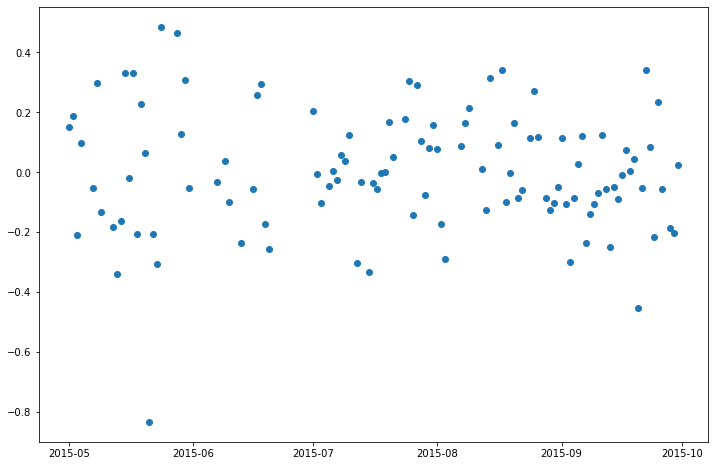

In [46]:
plt.clf()
fig = plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(data.index, resids, 'o')
plt.show()

## Independence

In [39]:
dw = durbin_watson(resids)
dw

1.7878370548053488

## Normality

In [40]:
shapiro(resids)

ShapiroResult(statistic=0.9738056063652039, pvalue=0.027684876695275307)

## Variance

In [43]:
ndata = resids.size
bartlett(resids[:ndata//2], resids[ndata//2:])

BartlettResult(statistic=6.410964763365371, pvalue=0.011341777487608562)

## We appear to be failing Normality and Variance

In [ ]:
# 